In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import explained_variance_score,mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

df=pd.read_csv('Data/2_Full_Data_D.csv', index_col=0)
sns.set(style='whitegrid')

In [54]:
df['State'] = df['Agency'].str.split(':').str[0]
df = df.drop(columns='city_state')
df.head()

,Agency,DODPurchase_Quantity,DOD_TotalValue,deaths,pct_of_pop_grad_degree,pct_of_pop_college_degree,pct_of_pop_high_school_degree,pct_below_povline,pctBPL_workft,pctBPL_workpt,...,education_services_city,social_services_city,public_welfare_city,police_city,fire_city,correction_city,inspection_city,envir_housing_city,parks_recreation_city,housing_commdevt_city
0,AK: ANCHORAGE POLICE DEPARTMENT,17536.0,899408.67,13.0,11.8,31.7,93.4,9.5,1.6,11.3,...,2573.19250,94.20250,2.64125,452.82875,349.27625,0.00000,20.9325,375.53625,105.89875,18.79750
1,AK: FAIRBANKS POLICE DEPARTMENT,1.0,689000.00,2.0,12.1,32.6,94.5,8.1,1.5,11.5,...,0.00000,0.00000,0.00000,274.78500,217.81750,0.00000,18.7525,13.59750,2.64250,0.00000
2,AK: ALASKA STATE TROOPERS,0.0,0.00,1.0,12.1,32.6,94.5,8.1,1.5,11.5,...,0.00000,0.00000,0.00000,274.78500,217.81750,0.00000,18.7525,13.59750,2.64250,0.00000
3,AL: MOBILE POLICE DEPARTMENT,29.0,55033.00,5.0,7.8,22.9,86.2,19.3,4.0,21.5,...,65.56375,35.62125,0.00000,248.83625,156.01375,39.10125,22.7675,466.86000,140.13750,14.40750
4,AZ: DOUGLAS POLICE DEPARTMENT,1.0,412000.00,1.0,13.5,31.9,88.3,17.8,4.0,23.8,...,0.00000,0.00000,0.00000,284.78375,166.14250,0.00000,0.0000,394.01250,100.42625,203.76875


In [75]:
dfd = pd.get_dummies(df['State'])

for series in dfd:
    dfd[series] = dfd[series].astype(float)
dfd = pd.concat([df.drop(columns=['State','Agency','City','city_name'],axis=1),dfd],axis=1)


In [76]:
dfd.dtypes

DODPurchase_Quantity             float64
DOD_TotalValue                   float64
deaths                           float64
pct_of_pop_grad_degree           float64
pct_of_pop_college_degree        float64
pct_of_pop_high_school_degree    float64
pct_below_povline                float64
pctBPL_workft                    float64
pctBPL_workpt                    float64
pctBPL_unempl                    float64
education_services_city          float64
social_services_city             float64
public_welfare_city              float64
police_city                      float64
fire_city                        float64
correction_city                  float64
inspection_city                  float64
envir_housing_city               float64
parks_recreation_city            float64
housing_commdevt_city            float64
AK                               float64
AL                               float64
AZ                               float64
CA                               float64
DE              

In [77]:
from sklearn.preprocessing import StandardScaler
X = dfd.drop(columns=['deaths']).values
y = dfd.deaths.values

In [78]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [80]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Modeling

## Model 1 - KNN

In [81]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score

In [82]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)

In [83]:
r2_score(y_test,y_pred)

-0.10375114364135407

In [84]:
param_grid = {'n_neighbors':np.arange(1,10),
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
knr_cv = GridSearchCV(knr, param_grid=param_grid, cv=5)
knr_cv.fit(X_train, y_train)
y_pred2 = knr_cv.predict(X_test)

knr_cv.best_params_

{'algorithm': 'auto', 'n_neighbors': 4}

In [85]:
knr2 = KNeighborsRegressor(n_neighbors=4)
knr2.fit(X_train, y_train)
y_pred3 = knr2.predict(X_test)

In [86]:
from sklearn.metrics import mean_squared_error, explained_variance_score
print("R2 Score: " + str(r2_score(y_test, y_pred3)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred3)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred3)))

R2 Score: -0.3567017383348583
MSE Score: 30.893229166666668
Explained Variance Score: -0.21736333485818848


Text(0, 0.5, 'Y_Pred Values')

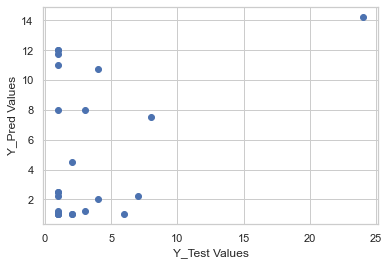

In [88]:
plt.scatter(x=y_test, y=y_pred3)
plt.xlabel('Y_Test Values')
plt.ylabel('Y_Pred Values')

## Model 2

In [89]:
import xgboost as xgb
from xgboost import XGBRegressor

xgbreg = XGBRegressor(random_state=42,silent=True)
xgbreg.fit(X_train,y_train)
y_pred4 = xgbreg.predict(X_test)


In [90]:
print("R2 Score: " + str(r2_score(y_test, y_pred4)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred4)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred4)))

R2 Score: -4.825043579042464
MSE Score: 132.64109649777944
Explained Variance Score: -4.353248639264217


In [91]:
param_grid = ({'n_estimators': np.arange(1,15),
               'max_depth': np.arange(1,15),
               'learning_rate':[0.1,0.3,0.5,0.7]})
xgbreg_cv = GridSearchCV(xgbreg, param_grid=param_grid, cv=5)
xgbreg_cv.fit(X_train, y_train)
y_pred5 = xgbreg_cv.predict(X_test)

In [92]:
xgbreg_cv.best_params_

{'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 3}

In [93]:
xgbreg2 = XGBRegressor(n_estimators=3, max_depth=1, learning_rate=0.3, booster='gbtree', random_state=42,silent=True)
xgbreg2.fit(X_train,y_train)
y_pred5 = xgbreg2.predict(X_test)

In [94]:
print("R2 Score: " + str(r2_score(y_test, y_pred5)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred5)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred5)))

#odd, results are not as strong as before using gridsearch.

R2 Score: 0.25843794766369954
MSE Score: 16.88598590007451
Explained Variance Score: 0.2618965207872819


In [95]:
features = pd.DataFrame(xgbreg.feature_importances_, index=dfd.columns[1:69])
features[features[0]>0].sort_values(by=0, ascending=False)

,0
public_welfare_city,0.174076
pct_of_pop_college_degree,0.169787
fire_city,0.124740
pct_of_pop_high_school_degree,0.080074
OH,0.076675
pctBPL_workft,0.069064
deaths,0.045964
pct_of_pop_grad_degree,0.042201
pct_below_povline,0.038709
pctBPL_workpt,0.033739


Text(0, 0.5, 'Y_Pred Values')

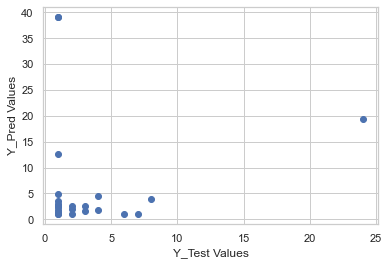

In [97]:
plt.scatter(x=y_test, y=y_pred4)
plt.xlabel('Y_Test Values')
plt.ylabel('Y_Pred Values')

## Model 3

In [98]:
from sklearn.linear_model import Lasso

In [99]:
lasso = Lasso(random_state=42)
lasso.fit(X_train,y_train)
y_pred6 = lasso.predict(X_test)

In [100]:
print("R2 Score: " + str(r2_score(y_test, y_pred6)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred6)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred6)))
lasso.get_params

R2 Score: 0.2532652488625876
MSE Score: 17.00377256235816
Explained Variance Score: 0.32045793714949766


<bound method BaseEstimator.get_params of Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)>

In [101]:
param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'max_iter': [500, 1000, 1500]
             }
lasso_cv = GridSearchCV(lasso, param_grid=param_grid, cv=5)
lasso_cv.fit(X_train, y_train)
y_pred3 = lasso_cv.predict(X_test)

lasso_cv.best_params_

{'fit_intercept': True, 'max_iter': 500, 'normalize': True}

In [102]:
lasso2 = Lasso(random_state=42, max_iter=500)
lasso2.fit(X_train,y_train)
y_pred7 = lasso2.predict(X_test)

In [103]:
print("R2 Score: " + str(r2_score(y_test, y_pred7)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred7)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred7)))

R2 Score: 0.2532652488625876
MSE Score: 17.00377256235816
Explained Variance Score: 0.32045793714949766


In [104]:
features3 = pd.DataFrame(lasso.coef_, index=dfd.columns[1:69])
features3[features3[0]>0].sort_values(by=0, ascending=False)

,0
CA,0.874716
AZ,0.454765
DOD_TotalValue,0.337979


## Model 4

In [105]:
from sklearn.linear_model import ElasticNetCV

In [106]:
enet_cv = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], cv=5)
enet_cv.fit(X_train, y_train)
y_pred8 = enet_cv.predict(X_test)

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3679432423653566, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.568538534984441, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1678218845236188, tolerance: 0.1358431818181818
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2638981859757905, tolerance: 0.1358431818181818
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37975651845192715, tolerance: 0.1358431818181818
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective d

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.51605148687605, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.75962331352463, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.40554672002122, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did n

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27158415668679936, tolerance: 0.26118863636363643
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28161032354540794, tolerance: 0.26118863636363643
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3296361181581915, tolerance: 0.26118863636363643
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.58069692270644, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.36438781103854, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.06413573688661, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did n

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2235385001841621, tolerance: 0.20627272727272727
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2737353459298504, tolerance: 0.20627272727272727
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23940041356760844, tolerance: 0.20627272727272727
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objectiv

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.66151037696326, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.76264234064968, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.74626807578551, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did n

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.46910067809546, tolerance: 0.1358431818181818
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.98566694776787, tolerance: 0.1358431818181818
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.835199075456785, tolerance: 0.1358431818181818
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23638436319066614, tolerance: 0.2209909090909091
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4824116275767665, tolerance: 0.26118863636363643
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.189138865145992, tolerance: 0.26118863636363643
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective 

/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.0693568289324, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.58440412425477, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.61478674138192, tolerance: 0.2534636363636364
  positive)
/Users/rachelruzzo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did no

In [107]:
print("R2 Score: " + str(r2_score(y_test, y_pred8)))
print("MSE Score: " + str(mean_squared_error(y_test,y_pred8)))
print("Explained Variance Score: " + str(explained_variance_score(y_test,y_pred8)))

R2 Score: -0.04758243669330753
MSE Score: 23.854325068870523
Explained Variance Score: 0.0


# Model Results

| Model | Explained Variance| Mean Squared Error| R2 Score | Features Dropped | 
| --- | --- | --- | --- | --- |
| Model 1. (KNeighbors Regression) | 0.14 | 0.62 | 0.089 | 'deaths' |
| Model 2. (XGB) | 0.065 | 0.64 | 0.064 | 'deaths' |
| Model 2.5 (XGB) | 0.065 | 0.64 | 0.065 | 'deaths', 'AK' |
| Model 3 (Lasso) | 0.003 | 0.72| -0.058| 'deaths' | 
| Model 3 (Elastic Nt) | -0.131 | 0.79| -0.16| 'deaths' | 



Model Selection: Model 2